In [ ]:
import os
from z3 import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def parse_dat_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
        m = int(lines[0].strip())
        n = int(lines[1].strip())
        l_values = list(map(int, lines[2].strip().split()))
        s_values = list(map(int, lines[3].strip().split()))
        distance_matrix = [list(map(int, line.strip().split())) for line in lines[4:]]
        
        return {
            'm': m,
            'n': n,
            'l_values': l_values,
            's_values': s_values,
            'distance_matrix': distance_matrix
        }

def read_dat_files(folder_path):
    dat_files = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    instances = {}
    
    for dat_file in dat_files:
        file_path = os.path.join(folder_path, dat_file)
        instances[dat_file] = parse_dat_file(file_path)
    
    return instances

folder_path = 'Instances'  # Adjust this path as necessary
instances = read_dat_files(folder_path)

# Display parsed data for verification
for filename, data in instances.items():
    print(f"Filename: {filename}")
    print(f"m: {data['m']}")
    print(f"n: {data['n']}")
    print(f"l_values: {data['l_values']}")
    print(f"s_values: {data['s_values']}")
    print(f"distance_matrix: {data['distance_matrix']}")
    print()

In [2]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    s = Solver()
    s.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        s.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        s.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Constraints: Define the travel times and ensure tours start and end at the origin
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        s.add(courier_distance[i] == travel_distance)
    
    # Constraint: Max distance is the maximum of all courier distances
    for i in range(m):
        s.add(max_distance >= courier_distance[i])
    
    # Binary search to minimize the maximum distance
    low, high = 0, sum(sum(row) for row in D)  # initial bounds for binary search
    optimal_solution = None

    while low <= high:
        mid = (low + high) // 2
        s.push()
        s.add(max_distance <= mid)
        if s.check() == sat:
            optimal_solution = (mid, s.model())
            high = mid - 1
        else:
            low = mid + 1
        s.pop()
    
    if optimal_solution:
        max_dist, model = optimal_solution
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)
        
        return max_dist, solution, routes
    else:
        return None

def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.show()

Instance: inst01.dat
Max Distance: 21
Courier 1: Items [3, 4, 6]
Courier 1 Route: [7, 3, 4, 6, 7]
Courier 2: Items [1, 2, 5]
Courier 2 Route: [7, 1, 2, 5, 7]


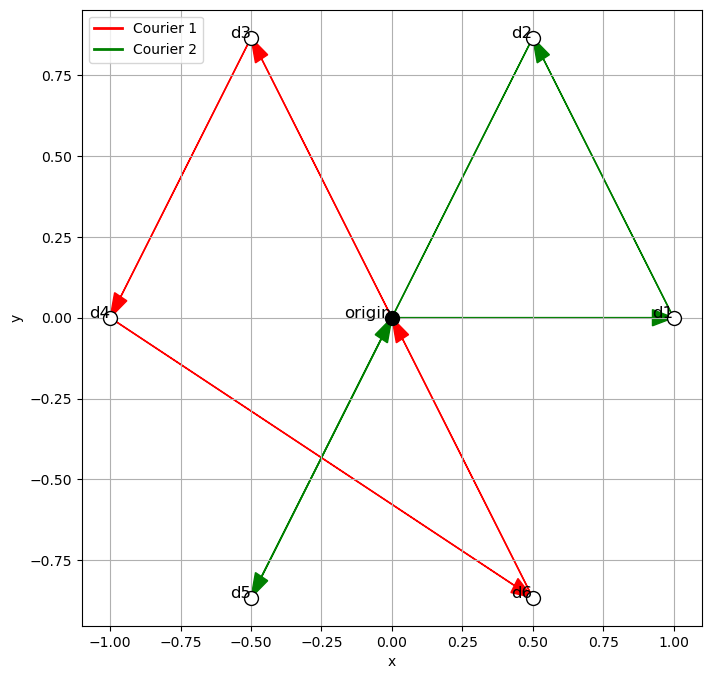

Instance: inst02.dat
Max Distance: 306
Courier 1: Items [5]
Courier 1 Route: [10, 5, 10]
Courier 2: Items [3, 6]
Courier 2 Route: [10, 3, 6, 10]
Courier 3: Items [1, 9]
Courier 3 Route: [10, 1, 9, 10]
Courier 4: Items [8]
Courier 4 Route: [10, 8, 10]
Courier 5: Items [2]
Courier 5 Route: [10, 2, 10]
Courier 6: Items [4, 7]
Courier 6 Route: [10, 4, 7, 10]


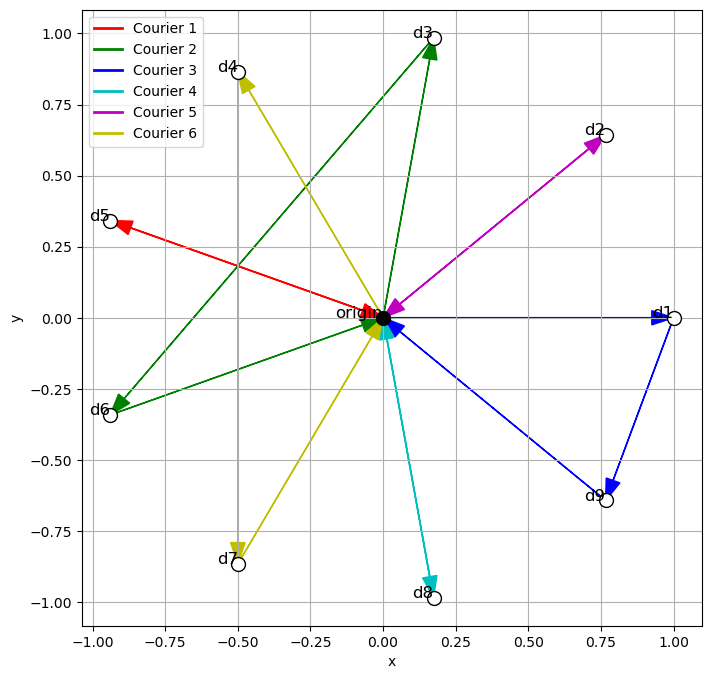

Instance: inst03.dat
Max Distance: 20
Courier 1: Items [3, 5, 6]
Courier 1 Route: [8, 3, 5, 6, 8]
Courier 2: Items [2, 4]
Courier 2 Route: [8, 2, 4, 8]
Courier 3: Items [1, 7]
Courier 3 Route: [8, 1, 7, 8]


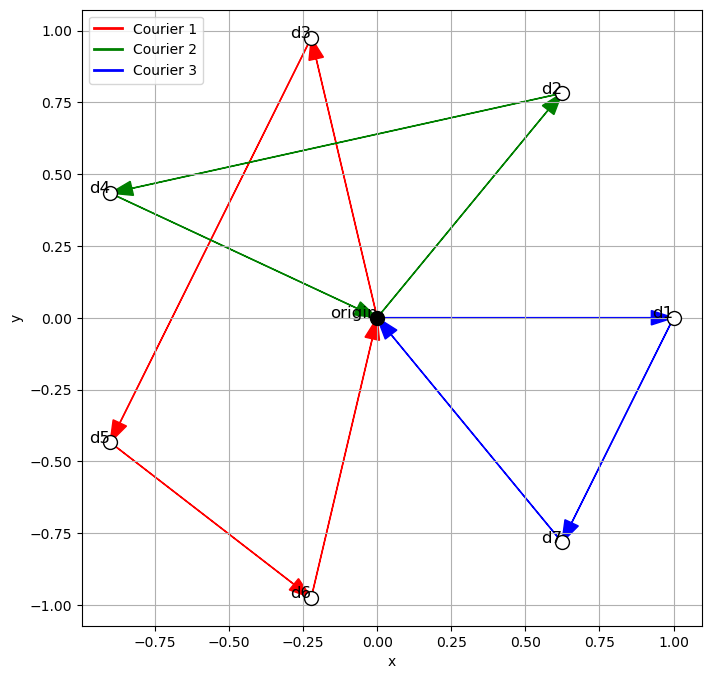

Instance: inst04.dat
Max Distance: 220
Courier 1: Items []
Courier 1 Route: [11, 11]
Courier 2: Items [1, 9]
Courier 2 Route: [11, 1, 9, 11]
Courier 3: Items [7, 10]
Courier 3 Route: [11, 7, 10, 11]
Courier 4: Items [4]
Courier 4 Route: [11, 4, 11]
Courier 5: Items [3, 5]
Courier 5 Route: [11, 3, 5, 11]
Courier 6: Items [6]
Courier 6 Route: [11, 6, 11]
Courier 7: Items [8]
Courier 7 Route: [11, 8, 11]
Courier 8: Items [2]
Courier 8 Route: [11, 2, 11]


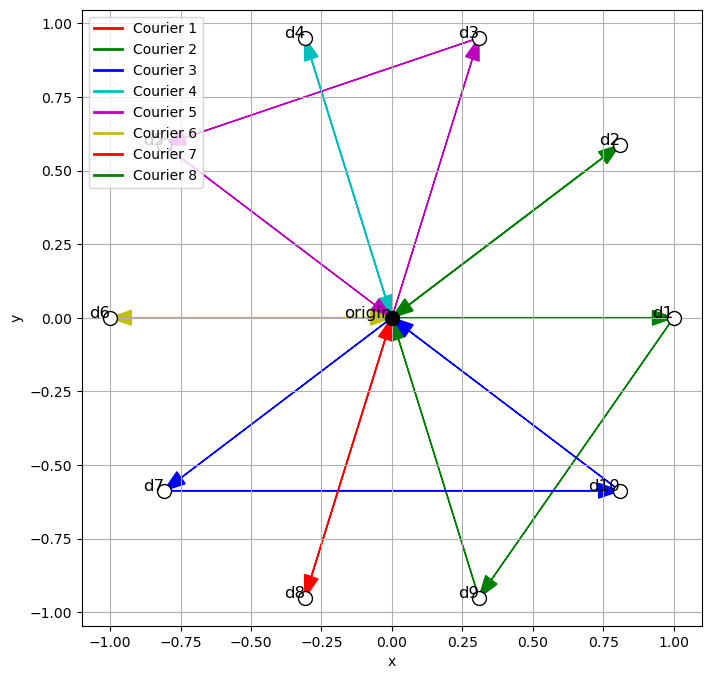

Instance: inst05.dat
Max Distance: 280
Courier 1: Items [2]
Courier 1 Route: [4, 2, 4]
Courier 2: Items [1, 3]
Courier 2 Route: [4, 1, 3, 4]


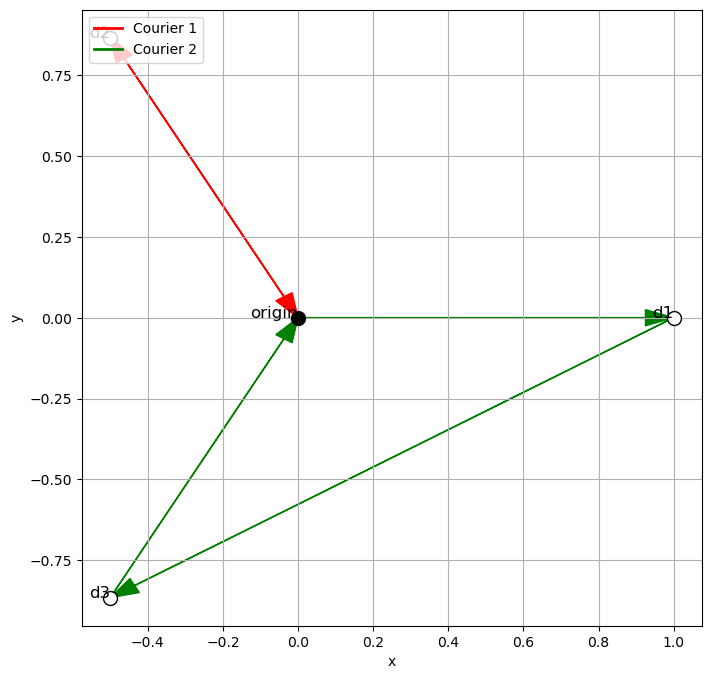

Instance: inst06.dat
Max Distance: 322
Courier 1: Items [5]
Courier 1 Route: [9, 5, 9]
Courier 2: Items [4]
Courier 2 Route: [9, 4, 9]
Courier 3: Items [8]
Courier 3 Route: [9, 8, 9]
Courier 4: Items [1, 7]
Courier 4 Route: [9, 1, 7, 9]
Courier 5: Items [3]
Courier 5 Route: [9, 3, 9]
Courier 6: Items [2, 6]
Courier 6 Route: [9, 2, 6, 9]


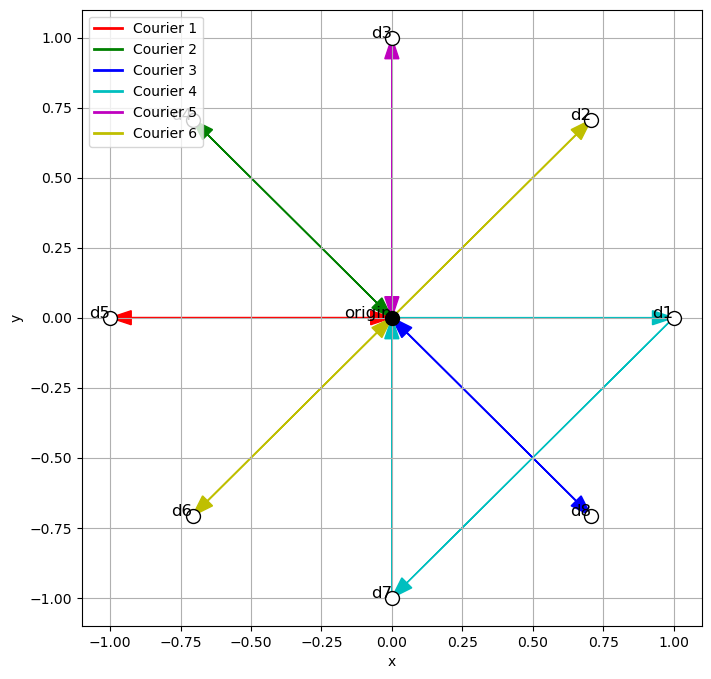

In [ ]:
# Solve each instance and plot the results
for filename, instance in instances.items():
    result = solve_mcp(instance)
    if result:
        max_distance, solution, routes = result
        print(f"Instance: {filename}")
        print(f"Max Distance: {max_distance}")
        for i, items in enumerate(solution):
            assigned_items = [j+1 for j, assigned in enumerate(items) if is_true(assigned)]
            print(f"Courier {i+1}: Items {assigned_items}")
            print(f"Courier {i+1} Route: {[x + 1 for x in routes[i]]}")  # Adjust for 1-based indexing in output
        plot_routes(routes, instance)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")